<a href="https://colab.research.google.com/github/mido-Jr/Transfer-learning/blob/main/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> In this Notebook we will classify images of dogs and cats using transfer learning from pre-trained network




# Genrel workFlow


1.   Data Preprocessing
2.   Create Base model
3.   Feature Extraction
4.   Model Evaluation



A **pre-trained** model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task. ☣











**The intuition** behind **transfer learning** for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset

In [1]:
# Setup

import os
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt

%matplotlib inline



# Data Preprocessing

We will download a dataset containing several thousand images of cats and dogs , then extract a zip file and create a training and validation 

In [2]:
_url_ = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip',origin = _url_,extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip),'cats_and_dogs_filtered')

train_dir = os.path.join(PATH,'train')
validation_dir = os.path.join(PATH,'validation')

Batch_Size = 32
IMG_SIZE=(160,160)

68616192/68606236 [==============================] - 0s 0us/step


print directories we working wit it

In [3]:
print(os.path.dirname(path_to_zip))
print(train_dir)
print(validation_dir)

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/validation


making a train and validation classes from data we extracted above

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=Batch_Size,
    image_size = IMG_SIZE
)

Found 2000 files belonging to 2 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=Batch_Size,
    image_size = IMG_SIZE
)

Found 1000 files belonging to 2 classes.


**showing the first nine images and labels from the training set**



In [6]:
class_name = train_dataset.class_names


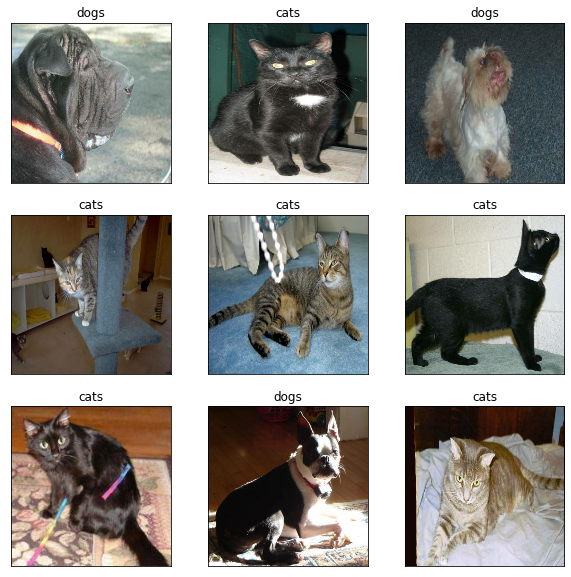

In [7]:
plt.figure(figsize=(10,10))

for image , labels in train_dataset.take(1):
  
  for i in range(9):

    ax = plt.subplot(3,3,i+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(class_name[labels[i]])



As the orignal dataset don`t have test set , we will create one.
**How ?**

Determine how many batchs of data available in the validation set then move 20% of them to a test set

In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches//5)
validation_dataset = validation_dataset.skip(val_batches//5)

In [9]:
print(f'number of validation batches = {tf.data.experimental.cardinality(validation_dataset)}')
print(f'number of test batches = {tf.data.experimental.cardinality(test_dataset)}')

number of validation batches = 26
number of test batches = 6


**configure the dataset for performance**

this will be better performance , you can visit [tens_api](https://www.tensorflow.org/guide/data_performance)

In [10]:
autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size = autotune)
validation_dataset = validation_dataset.prefetch(buffer_size = autotune)
test_dataset = test_dataset.prefetch(buffer_size = autotune)

**Use Data Augmentation**

nice trick to reduce overfitting as your data is not large enough

In [11]:
# data augmentation layers [1]

data_augmentation = tf.keras.Sequential([              
          tf.keras.layers.RandomFlip(mode='horizontal'),
          tf.keras.layers.RandomRotation(factor=.2)
          ])



# Note > this layers active only while training "model.fit" and inactive when using "model.evaluate"

**apply these layers to sample image and see the result.**

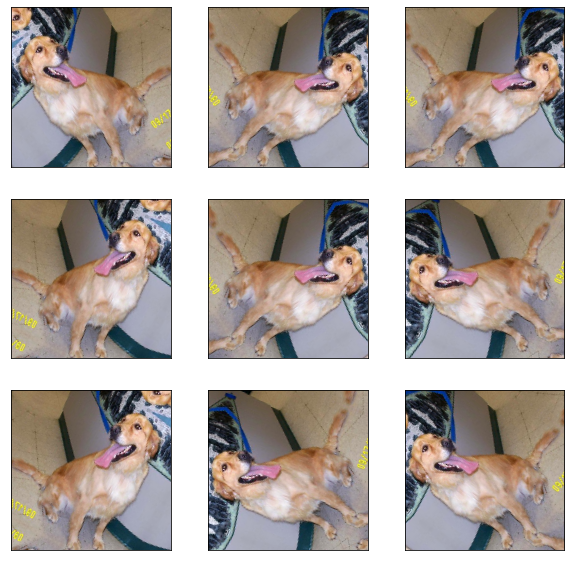

In [12]:
for image , _ in train_dataset.take(1):

  plt.figure(figsize = (10,10))
  sample_image = image[0]

  for i in range(9):

    ax = plt.subplot(3,3,i+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    aug_img = data_augmentation(tf.expand_dims(sample_image,0))
    plt.imshow(aug_img[0]/255)
    

**rescale pixels value**

we will use `tf.keras.applications.MobileNetV2` for use as base model
but this model expect pixel value in [1,-1] while pixel value in our images in [0,255]  , so we need to rescaling them

In [13]:
# rescaling layer [2]

preprocess_input =  tf.keras.applications.mobilenet_v2.preprocess_input 

# Create the base model from pre-trained 

we will create base model from the **MobileNetV2** please check API [Here](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2)

In [14]:
from tensorflow.python.util.traceback_utils import include_frame
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape = IMG_SHAPE,
    include_top = False, # pick which layer will use and top layers not include here
    weights = 'imagenet'
)

9420800/9406464 [==============================] - 0s 0us/step


In [15]:
# base model layers [3]

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch) 
print(feature_batch.shape)

(32, 5, 5, 1280)


#Feature Extraction

**Note** --

we use base model from `MobileNetV2` this model has many layers already, we pick some of these layers but need to freeze what we pick , it is Important step

In [16]:
base_model.trainable = False

In [17]:
# lets take a look about base_model architecture
#base_model.summary()


> from summary above you can see `BatchNormalization layer`
you should see [API](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) for this layer and understand why shoud make `layer.trainable = False` 

> you should keep the `BatchNormalization layers` in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will **destroy** what the model has learned.



**Add a classification head** 


In [18]:
# feature extractor layers [4]

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_average_layer = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1) # note you don`t need activation here as output will be raw prediction 0 or 1 
predication_batch = prediction_layer(feature_average_layer)

print(predication_batch.shape)


(32, 1)


**Building a model by chaining all together**

In [19]:
inputs = tf.keras.Input(shape = (160,160,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x,training =False) # note batchnormalization 
x = global_average_layer(x)
x = tf.keras.layers.Dropout(.2)(x) # reduce overfitting
outputs = prediction_layer(x)
model = tf.keras.Model(inputs,outputs)


**compile the model**

In [20]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
#showing model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [22]:
# finally training the model
initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data = validation_dataset
                    )

Epoch 1/10
63/63 [==============================] - 9s 78ms/step - loss: 0.5880 - accuracy: 0.6645 - val_loss: 0.4130 - val_accuracy: 0.7834
Epoch 2/10
63/63 [==============================] - 4s 59ms/step - loss: 0.4466 - accuracy: 0.7735 - val_loss: 0.3069 - val_accuracy: 0.8502
Epoch 3/10
63/63 [==============================] - 4s 59ms/step - loss: 0.3670 - accuracy: 0.8225 - val_loss: 0.2480 - val_accuracy: 0.8923
Epoch 4/10
63/63 [==============================] - 4s 60ms/step - loss: 0.3160 - accuracy: 0.8615 - val_loss: 0.2019 - val_accuracy: 0.9146
Epoch 5/10
63/63 [==============================] - 4s 59ms/step - loss: 0.2773 - accuracy: 0.8785 - val_loss: 0.1875 - val_accuracy: 0.9183
Epoch 6/10
63/63 [==============================] - 4s 58ms/step - loss: 0.2590 - accuracy: 0.8820 - val_loss: 0.1610 - val_accuracy: 0.9369
Epoch 7/10
63/63 [==============================] - 4s 59ms/step - loss: 0.2409 - accuracy: 0.8955 - val_loss: 0.1447 - val_accuracy: 0.9480
Epoch 8/10
63

In [23]:
loss, accuracy = model.evaluate(test_dataset)

print("Test Model loss: {:.2f}".format(loss))
print("Test Model accuracy: {:.2f}".format(accuracy))

6/6 [==============================] - 0s 41ms/step - loss: 0.1078 - accuracy: 0.9792
Test Model loss: 0.11
Test Model accuracy: 0.98


# Model Evaluation

look at the learning curves of the training and validation accuracy/loss

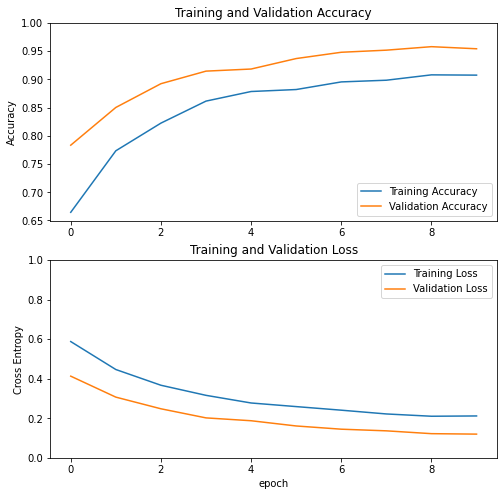

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()